This notebook uses uses an Autoencoders on the [CIFAR10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).


# Load Data

In [1]:
import sys 
sys.version_info > (3, 5)

import numpy as np
import tensorflow as tf
assert tf.__version__ > "2.0"
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
[X_train_full, y_train_full], [X_test, y_test] = keras.datasets.cifar10.load_data()
X_train_full = X_train_full / 255. #scale data so it is between 0 to 1
X_test = X_test / 255.

# Explore and Prepare Data

We already know a lot about the famous CIFAR10 dataset, but below is a quick summary on the shape and the sort of images we expect.

In [3]:
X_train_full.shape

(50000, 32, 32, 3)

In [4]:
# split into validation and train datasets 
X_train, y_train = X_train_full[10000:], y_train_full[10000:]
X_valid, y_valid = X_train_full[:10000], y_train_full[:10000]

In [5]:
X_train.shape

(40000, 32, 32, 3)

In [6]:
np.unique(y_train) # there are 10 classes

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [7]:
# lets get the class names as specified on the website.
class_names = [
               'airplane', 'automobile', 'bird',
               'cat', 'deer', 'dog', 'frog', 
               'horse', 'ship', 'truck'
               ]

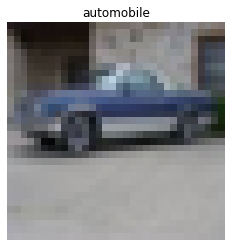

In [8]:
def plot_cifar10_data(image=X_train[0], label_index=y_train[0]):
  """
  Function to plot CIFAR10 data.
  """
  plt.title(class_names[label_index.item()])
  plt.imshow(image)
  plt.axis('off')

plot_cifar10_data()

In [9]:
def plot_multiple_images(X_train=X_train, y_train=y_train, n_cols=None, n_rows=None):
  """
  Function that plots multiple CIFAR10 data.
  """
  plt.figure(figsize=(n_cols*2, n_rows*2))
  for index in range(n_cols * n_rows):
    plt.subplot(n_rows, n_cols, index + 1)
    plot_cifar10_data(image=X_train[index], label_index=y_train[index])

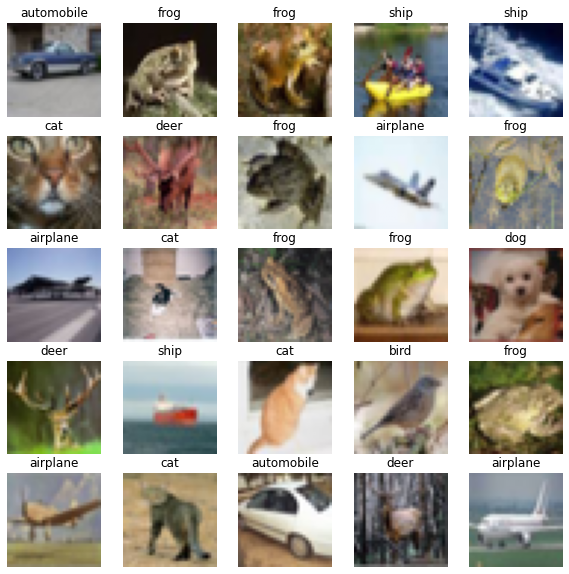

In [10]:
plot_multiple_images(X_train=X_train, y_train=y_train, n_cols=5, n_rows=5)
plt.show()

Now that we have scaled the data, lets build a few Autoencoder models.

--- 
# To do

# Train Models

In [11]:
# set the seed so model is reproducible
tf.random.set_seed(42)
np.random.seed(42) 

## Denoiser Autoencoder

## Variation Autoencoder

## Deep Convolutional Generative Adversial Network (DCGAN)

In [12]:
# define discriminator and generator 


# Best Model